[Install](https://conda.io/docs/user-guide/install/index.html) Jupyter Notebook.

# $$Python\ Workshop\ 2019$$

Tədbirin gündəliyi:
* Kaggle nədir və Kaggle vasitəsilə neçə data elmini öyrənmək olar;
* Məlumat analizində Python-nun yeri;
* Real nümunə üzərində məlumat analizi;

Real nümunə haqqında:
* **`Data collection / web crawling`** (məlumat toplanması) - ən böyük onlayn iş elanı veb səhifəsindən məlumatların avtomatik götürülməsi və faylda saxlanılması;
* **`Data cleaning`** (məlumat təmizlənməsi) - dəyişənlərin tipinin dəyişdirilməsi, catışmayan məlumatların bərpa olunması, artıq sətrlərin təmizlənməsi;
* **`Feature generation`** (yeni dəyişənlərin yaradılması) - əldə olan məlumatlardan yenisinin yaradılması, misal üçün: elanın mətnindən hansı dildə yazılması;
* **`Data visualizatoin`** (məlumatların təsviri) - məlumatların vizual təqdim olunması;

In [1]:
'#'.join(ch for ch in 'python')

'p#y#t#h#o#n'

## $$The\ Zen\ of\ Python$$

In [2]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


Understanding `The Zen of Python` via [examples](https://artifex.org/~hblanks/talks/2011/pep20_by_example.html).

## $$1.\ Import\ packages$$

In [3]:
%matplotlib inline

import requests
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import langdetect

from wordcloud import WordCloud

## $$2.\ Import\ data\ from\ website$$

In [4]:
# if `jobs.csv` exist don't extract data from website

file_name = 'jobs.csv'
url = 'http://jobsearch.az/'

if not os.path.isfile(file_name):
    print("File doesn't exit. Extract from website.")
    html = requests.get(url).content
    df_list = pd.read_html(html)
    jobs = df_list[9]
    # export to csv
    jobs.to_csv('jobs.csv', index=False)
else:
    print("File exist. Read from file.")
    jobs = pd.read_csv(file_name)

File exist. Read from file.


Remove first column and put first row as column.

In [5]:
# jobs.drop(columns=[jobs.columns[0]], axis=1, inplace=True) # remove first column
jobs.columns = jobs.iloc[0, :] # rename column to first row
jobs = jobs.iloc[1:, :] # remove first row

## $$3.\ Data\ cleaning$$

In [6]:
print('Dimension of the dataset :', jobs.shape)
jobs.head()

Dimension of the dataset : (691, 4)


,POSITION,EMPLOYER,POSTED,DEADLINE
1,Специалист по продаже финансовых услуг (new),Invest AZ QSC,2019-01-12,2019-02-11
2,Programmer (new),IT/Telecom Company,2019-01-11,2019-01-31
3,Maliyyə mütəxəssisi (new),Sirab ASC,2019-01-11,2019-02-10
4,Sürücü (new),My Broker Customs Representation,2019-01-11,2019-02-10
5,Satış nümayəndəsi (Soyuq satış) (new),Nurgun Holding,2019-01-11,2019-02-10


Number of missing values per column.

In [7]:
jobs.isnull().sum()

0
POSITION    0
EMPLOYER    0
POSTED      0
DEADLINE    0
dtype: int64

Get types per column.

In [8]:
jobs.get_dtype_counts()

object    4
dtype: int64

## $$4.\ Feature\ generation$$

Dummy variable to seperate new and old features.

In [9]:
def is_new_job(pos):
    '''Return dummy variable about '''
    return 'New' if pos.split()[-1] == '(new)' else 'Old'

In [10]:
jobs = jobs.assign(is_new = jobs.POSITION.apply(lambda x: is_new_job(x)))

Remove `(new)` tag from job position.

In [11]:
def clean_position(pos):
    '''Cleaning Positions'''
    pos = pos.lower()
    pos_clean = ' '.join(w for w in pos.split() if w != '(new)')
    pos_clean = pos_clean.strip()
    
    return pos_clean

In [12]:
jobs = jobs.assign(POSITION = jobs.POSITION.apply(lambda x: clean_position(x)))

Convert string to date type. Add datetime variables:

* Weekday
* Month

In [13]:
jobs.POSTED = pd.to_datetime(jobs.POSTED) # convert to date type
jobs.DEADLINE = pd.to_datetime(jobs.DEADLINE) # convert to date type

month_name = {
    1 : 'Yanvar',
    2 : 'Fevral',
    3 : 'Mart',
    4 : 'Aprel',
    5 : 'May',
    6 : 'Iyun',
    7 : 'Iyul',
    8 : 'Avqust',
    9 : 'Sentyabr',
    10 : 'Oktyabr',
    11 : 'Noyabr',
    12 : 'Dekabr'
}

jobs = jobs.assign(posted_month = jobs.POSTED.dt.month.map(month_name))
jobs = jobs.assign(posted_weekday = jobs.POSTED.dt.weekday_name)

Find out `position` language, in which language the position was published.

In [14]:
def convert_language(lang):
    '''Convert language name and group them'''
    if lang == 'tr':
        return 'az'
    elif lang in ['en', 'ru']:
        return lang
    else:
        return 'other'

In [15]:
jobs = jobs.assign(position_lang = jobs.POSITION.apply(lambda x: langdetect.detect(x)))
jobs = jobs.assign(position_lang = jobs['position_lang'].map(convert_language))

In [16]:
jobs.position_lang.value_counts(normalize=True) * 100

other    38.784370
az       34.876990
en       18.089725
ru        8.248915
Name: position_lang, dtype: float64

In [17]:
jobs[jobs.position_lang == 'other'].head()

,POSITION,EMPLOYER,POSTED,DEADLINE,is_new,posted_month,posted_weekday,position_lang
2,programmer,IT/Telecom Company,2019-01-11,2019-01-31,New,Yanvar,Friday,other
6,"korporativ sığorta şöbəsi, assistent",PASHA Life,2019-01-11,2019-02-10,New,Yanvar,Friday,other
9,elektrik,Company,2019-01-11,2019-02-10,New,Yanvar,Friday,other
10,sosial media/it mütəxəssis,Yerli İdarəetməyə Yardım İctimai Birliyi,2019-01-11,2019-02-10,New,Yanvar,Friday,other
12,mühasib,NOVCO Group of Companies,2019-01-11,2019-02-10,New,Yanvar,Friday,other


Get type of `employer`

In [18]:
# get last word from EMPLOYER
emp_type = jobs.EMPLOYER.apply(lambda x: x.split()[-1])

In [19]:
emp_type.value_counts(normalize=False).head(10) # top 10 employer type

LLC             127
Company          47
MMC              38
ASC              28
Azerbaijan       22
Bank             21
Holding          18
Construction     18
Baku             18
Group            16
Name: EMPLOYER, dtype: int64

We have the most popular employer type.

In [20]:
def get_employer_type(employer):
    '''Get employer type'''
    emp_types = ['LLC', 'MMC', 'ASC', 'Group', 'Holding', 'Bank', 'LTD']
    last_word = employer.split()[-1]
    return last_word if last_word in emp_types else 'Other'

In [21]:
jobs = jobs.assign(employer_type = jobs.EMPLOYER.apply(lambda x: get_employer_type(x)))

In [22]:
jobs.employer_type.value_counts(normalize=True) * 100

Other      62.083936
LLC        18.379161
MMC         5.499276
ASC         4.052098
Bank        3.039074
Holding     2.604920
Group       2.315485
LTD         2.026049
Name: employer_type, dtype: float64

## $$5.\ Visualization$$

In [23]:
jobs.head()

,POSITION,EMPLOYER,POSTED,DEADLINE,is_new,posted_month,posted_weekday,position_lang,employer_type
1,специалист по продаже финансовых услуг,Invest AZ QSC,2019-01-12,2019-02-11,New,Yanvar,Saturday,ru,Other
2,programmer,IT/Telecom Company,2019-01-11,2019-01-31,New,Yanvar,Friday,other,Other
3,maliyyə mütəxəssisi,Sirab ASC,2019-01-11,2019-02-10,New,Yanvar,Friday,az,ASC
4,sürücü,My Broker Customs Representation,2019-01-11,2019-02-10,New,Yanvar,Friday,az,Other
5,satış nümayəndəsi (soyuq satış),Nurgun Holding,2019-01-11,2019-02-10,New,Yanvar,Friday,az,Holding


In [24]:
jobs.employer_type.value_counts()

Other      429
LLC        127
MMC         38
ASC         28
Bank        21
Holding     18
Group       16
LTD         14
Name: employer_type, dtype: int64

Timeline of job publishment.

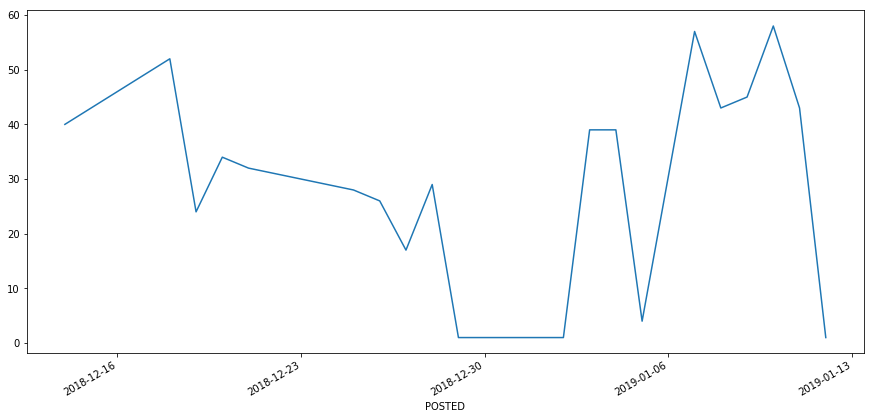

In [25]:
fig, ax = plt.subplots(figsize=(15,7))
jobs.groupby(['POSTED'])['POSTED'].count().plot(ax=ax)

In [26]:
jobs.POSTED.value_counts().head() # top 6 date with number of job ads

2019-01-10    58
2019-01-07    57
2018-12-18    52
2018-12-17    49
2019-01-09    45
Name: POSTED, dtype: int64

The most frequent `Employer` with jobs ads.

In [27]:
jobs.EMPLOYER.value_counts().head(10)

Company                                           25
BOS Shelf LLC                                     17
Sumgait Technologies Park LLC                     17
PASHA Construction                                10
FINCA Azerbaijan LLC                              10
Nurgun Holding                                    10
Optimal Electronics LLC                           10
Metak                                              9
ARÇELIK ticarət markasının rəsmi distribyutoru     8
Ateshgah Sigorta                                   8
Name: EMPLOYER, dtype: int64

The most frequent `Position`.

In [28]:
jobs.POSITION.value_counts().head(10)

mühasib                   19
baş mühasib                7
i̇ngilis dili müəllimi     6
sürücü                     5
satış məsləhətçisi         4
reception                  4
accountant                 4
satış meneceri             4
anbardar                   4
planning engineer          3
Name: POSITION, dtype: int64

When the most popular day to publish job description.

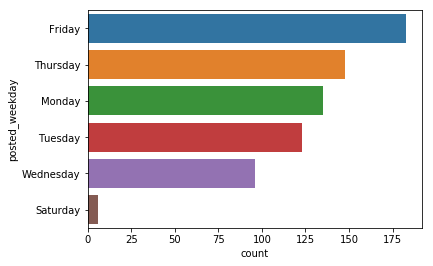

In [29]:
sns.countplot(y=jobs.posted_weekday, 
              order = jobs.posted_weekday.value_counts().index)

Frequency of the job insertion.

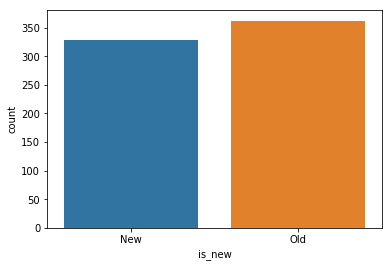

In [30]:
sns.countplot(jobs.is_new)

Frequency of the `employer type`

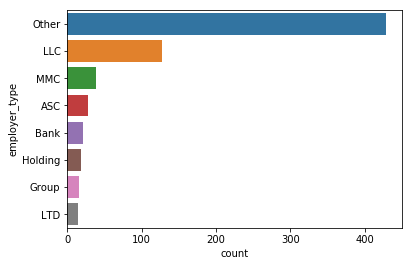

In [31]:
sns.countplot(y=jobs.employer_type,
              order=jobs.employer_type.value_counts().index)

Frequency of the `position language`

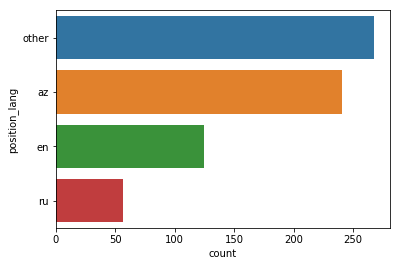

In [32]:
sns.countplot(y=jobs.position_lang,
              order=jobs.position_lang.value_counts().index)

In [33]:
jobs.head()

,POSITION,EMPLOYER,POSTED,DEADLINE,is_new,posted_month,posted_weekday,position_lang,employer_type
1,специалист по продаже финансовых услуг,Invest AZ QSC,2019-01-12,2019-02-11,New,Yanvar,Saturday,ru,Other
2,programmer,IT/Telecom Company,2019-01-11,2019-01-31,New,Yanvar,Friday,other,Other
3,maliyyə mütəxəssisi,Sirab ASC,2019-01-11,2019-02-10,New,Yanvar,Friday,az,ASC
4,sürücü,My Broker Customs Representation,2019-01-11,2019-02-10,New,Yanvar,Friday,az,Other
5,satış nümayəndəsi (soyuq satış),Nurgun Holding,2019-01-11,2019-02-10,New,Yanvar,Friday,az,Holding


## Word Cloud of Position

In [34]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=45,
        max_font_size=50, 
        scale=15,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

### POSITION

`AZ`

### `long version`

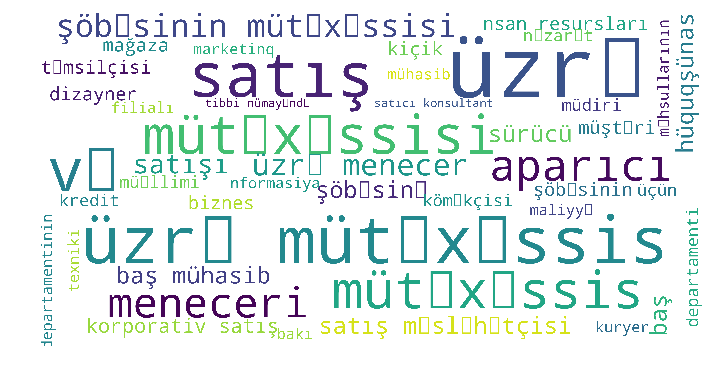

In [35]:
filter_by_lang = jobs.POSITION[jobs.position_lang == 'az']
text = []

# seperate each word from `position`
for sen in filter_by_lang.str.split(): # for each sentence
    for w in sen: # for each word
        text.append(w)

# combine into a string
text = ' '.join(text)

# word cloud
show_wordcloud(text)

### `short verion`

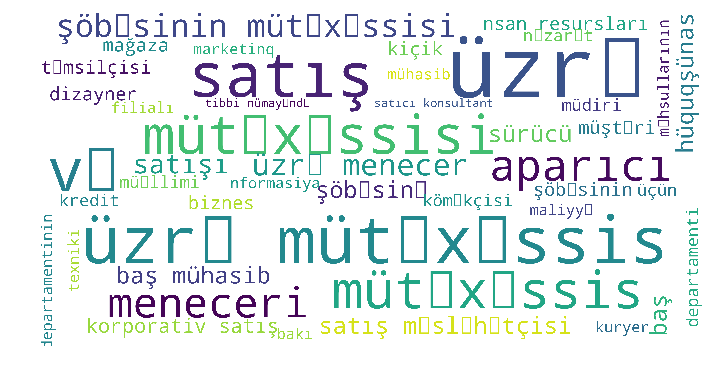

In [36]:
text = ' '.join(w for sen in jobs.POSITION[jobs.position_lang == 'az'].str.split() for w in sen)
show_wordcloud(text)

`EN`

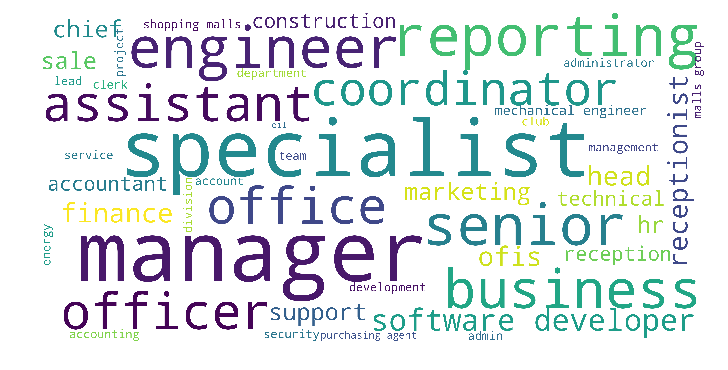

In [37]:
text = ' '.join(w for sen in jobs.POSITION[jobs.position_lang == 'en'].str.split() for w in sen)
show_wordcloud(text)

`RU`

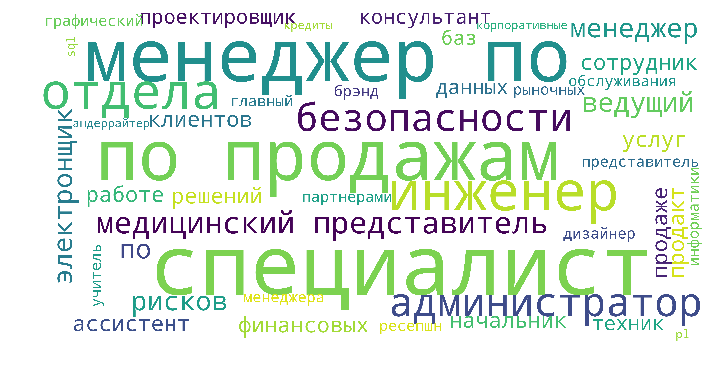

In [38]:
text = ' '.join(w for sen in jobs.POSITION[jobs.position_lang == 'ru'].str.split() for w in sen)
show_wordcloud(text)

`OTHER`

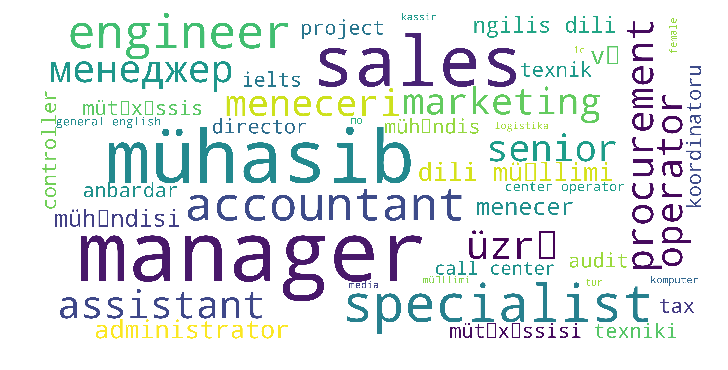

In [39]:
text = ' '.join(w for sen in jobs.POSITION[jobs.position_lang == 'other'].str.split() for w in sen)
show_wordcloud(text)

## EMPLOYER

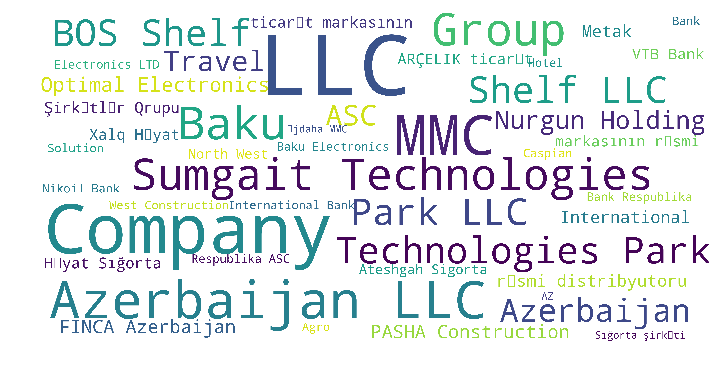

In [40]:
text = ' '.join(w for sen in jobs.EMPLOYER.str.split() for w in sen)
show_wordcloud(text)

Save processed data into `csv`.

In [41]:
jobs.to_csv('jobs_processed.csv', index=False)